# Attention-based word segmentation with TrOCR

This notebook shows a way to estimate the word boundaries from the model's encoder-decoder attention.


## Load the model and input image

We use the Swedish TrOCR model from Riksarkivet.

In [153]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_pretrained("Riksarkivet/trocr-base-handwritten-hist-swe-2").to("cuda")
processor = TrOCRProcessor.from_pretrained("Riksarkivet/trocr-base-handwritten-hist-swe-2")

Load an input image.

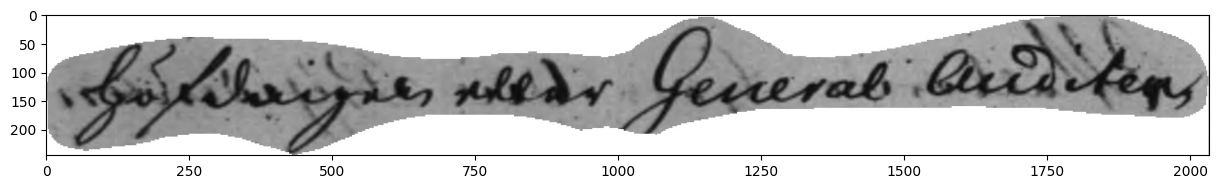

In [155]:
import matplotlib.pyplot as plt

from htrflow.utils.imgproc import read


plt.rcParams["figure.figsize"] = [15, 10]


img = read("../../examples/images/lines/A0068699_00021_region0_line2.jpg")
plt.imshow(img)

## Run the model

Note the arguments passed to `model.generate`. Setting `return_dict_in_generate` and `output_attentions` to `True` makes the model return the attention matrices. It is also important to set `num_beams` to 1, otherwise the output attention matrices may not be aligned with the tokens. (Not sure why, but it could be related to this: https://discuss.huggingface.co/t/t5-why-do-we-have-more-tokens-expressed-via-cross-attentions-than-the-decoded-sequence/31893)

In [156]:
inputs = processor([img], return_tensors="pt").pixel_values.to("cuda")
output = model.generate(inputs, return_dict_in_generate=True, output_attentions=True, num_beams=1, interpolate_pos_encoding=True)
print(processor.decode(output.sequences[0], skip_special_tokens=True))

Höfdingen eller General Auditeu¬


## Get the attention map for each token

These are the output tokens:

In [157]:
token_ids = output.sequences[0]
tokens = processor.batch_decode(token_ids)
print(tokens)

['<s>', '<s>', '<s>', 'H', 'ö', 'f', 'ding', 'en', ' e', 'ller', ' General', ' Aud', 'ite', 'u', '�', '�', '</s>']


The output `output.cross_attentions` is a list of attention at each step of the decoding process. We use the last one, `output.cross_attentions[-1]`, which includes information about the entire output sequence. It has shape $(12, 1, 16, n, L)$, where 12 is the number of layers in the model, 1 is the number of beams (which we excplicitly set to 1), 16 is the number of attention heads in each layer, $n$ is the number of output tokens, and $L$ is the length of the input sequence.

These are aggregated to the shape $(n, L)$, an attention map mapping each of the $n$ input tokens to each patch of the input image. We take the mean over all attention heads and sum over all layers. There are lots of ways to do this, this seems to work fine for word segmentation.

In [158]:
import torch


# Attention in the final decoding step, with shape
# (n layers, n beams (=1), n attention heads, output sequence length, input sequence length)
# With the default settings of TrOCR, this should be (12, 1, 16, x, 577)
cross_attention = torch.stack(output.cross_attentions[-1])
print(cross_attention.shape)

# Take the mean attention over each attention head and sum over all layers.
# There are other ways to do this! This seems to work fine for word segmentation.
agg_attention = cross_attention.mean(axis=2).sum(axis=0).squeeze()
print(agg_attention.shape)

torch.Size([12, 1, 16, 16, 577])
torch.Size([16, 577])


#### What is the length of the input sequence, $L$?

The length of the input sequence is the same as the number of image patches plus one extra token. TrOCR cuts the input image into square patches. With the default settings of TrOCR, the patch size is $16$ pixels, and the image size is $384$, which makes the "patchified" image $24$ x $24$. The image patches are then flattened and an extra token is added, which makes the length of the input sequence $24\cdot24 + 1=577$.

To get the attention maps, we need to discard the extra token and reshape the $L$ dimension back to $24$ x $24$.

In [159]:
image_height = processor.image_processor.size["height"]
image_width = processor.image_processor.size["width"]
patch_size = model.encoder.config.patch_size

attention_map_size = (image_height // patch_size, image_width // patch_size)
print(attention_map_size)

assert attention_map_size[0] * attention_map_size[1] + 1 == agg_attention.shape[-1]

(24, 24)


Plot the resulting atttentions.

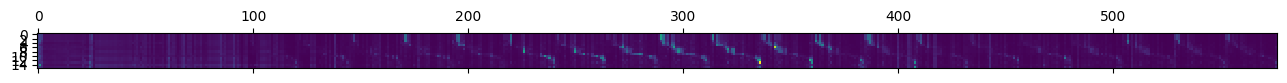

In [160]:
def plot_attentions(token_attentions):
    for i, (token, attentions) in enumerate(token_attentions):
        plt.subplot(4, 6, i + 1)
        plt.imshow(torch.reshape(attentions, attention_map_size).cpu())
        plt.title(repr(token))

    plt.tight_layout()


plt.rcParams["figure.figsize"] = [20, 10]

plt.matshow(agg_attention.cpu()[:, :])
agg2 = agg_attention - agg_attention.mean()
agg2[agg2 < 0] = 0
agg2 = agg2[:, 1:]
token_attentions = list(zip(tokens[1:], agg2))

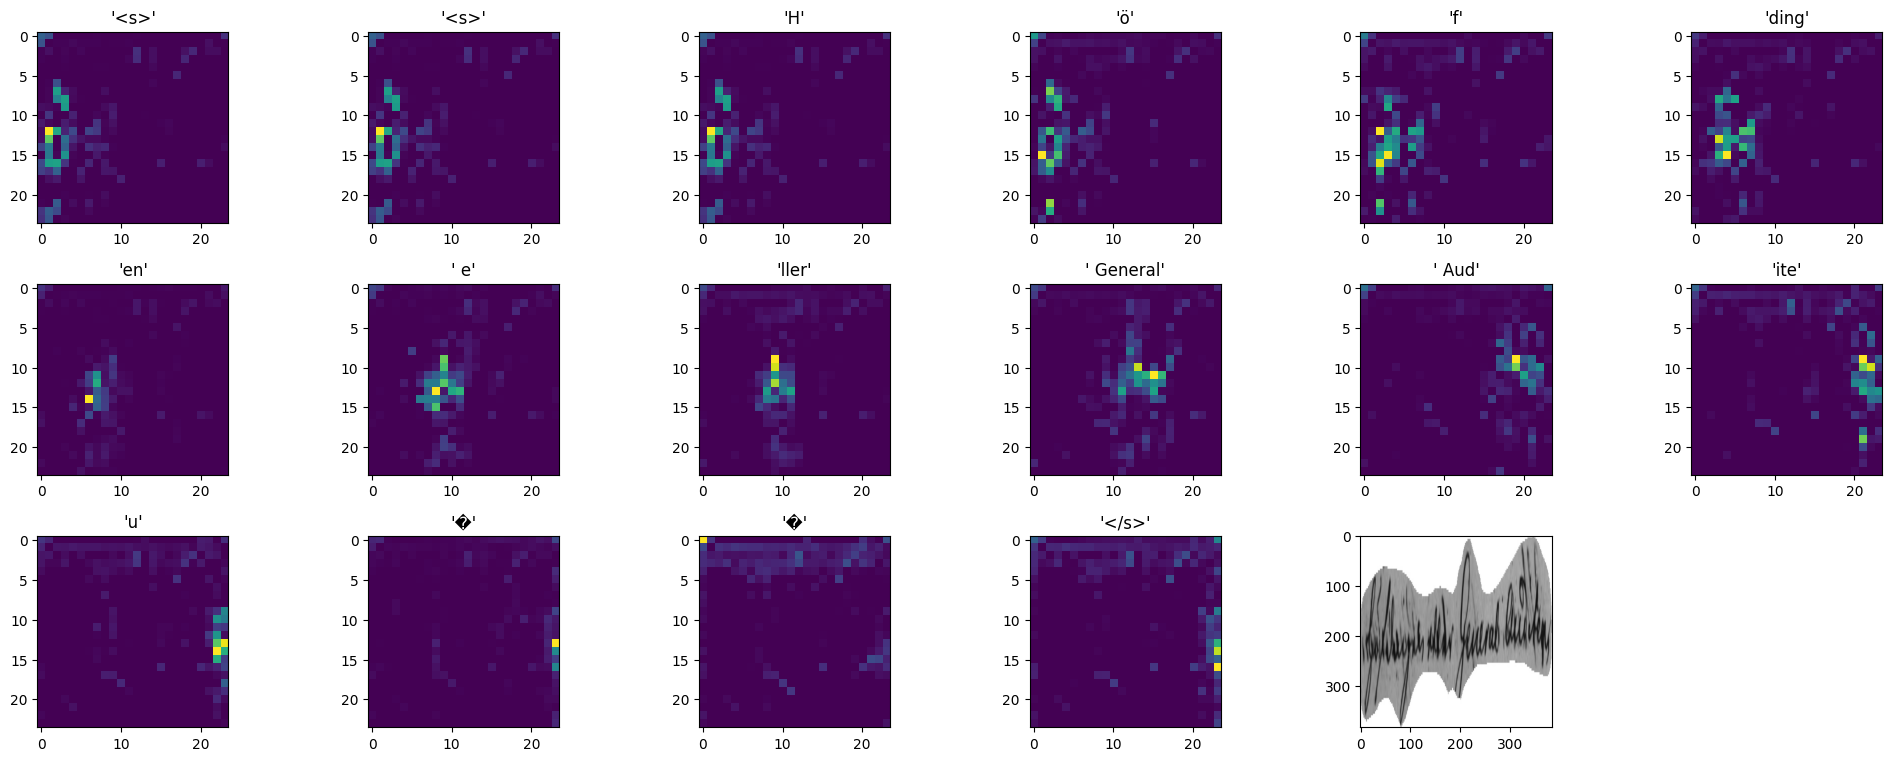

In [161]:
plot_attentions(token_attentions)

# Plot original reshaped image
import cv2
im2 = cv2.resize(img.copy(), (image_width, image_height), interpolation=cv2.INTER_LINEAR)
plt.subplot(4, 6, len(tokens))
plt.imshow(im2)

## Combine token attentions to word attentions

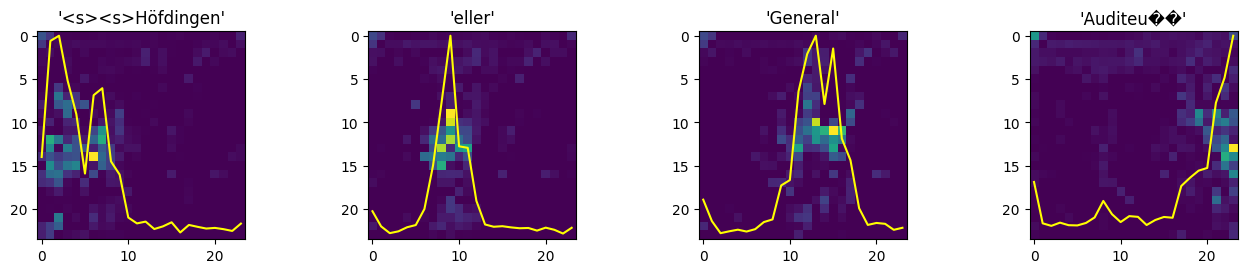

In [162]:
current_word = []
word_attentions = []
plt.rcParams["figure.figsize"] = [20, 10]

for i, ta in enumerate(token_attentions):

    first_token = ta[0]
    is_new_word = first_token.startswith(" ") and len(first_token) > 1
    is_last_word = i + 1 == len(token_attentions)

    if is_new_word or is_last_word:
        word = "".join(token for token, _ in current_word)

        # Compute the word's combined attention heatmap by taking
        # the element-wise max attention value
        text_tokens = [(token, token_attention) for token, token_attention in current_word if token not in ("<s>", "</s>")]
        _, word_attention = text_tokens[0]
        for token, token_attention_map in text_tokens[1:]:
            word_attention = torch.maximum(word_attention, token_attention_map)

        word_attentions.append((word.strip(), word_attention))
        current_word = []

    current_word.append(ta)

plot_attentions(word_attentions)

norms = []
plt.rcParams["figure.figsize"] = [5, 3]

for i, (_, attention) in enumerate(word_attentions):
    attention = torch.reshape(attention, attention_map_size)
    cols = attention.sum(axis=0)  # attention.sum(axis=0)
    norm = cols / cols.max()
    norms.append(norm)
    plt.subplot(4, 6, i + 1)
    plt.plot((attention_map_size[0] - 1) * (1 - norms[-1].cpu()), color="yellow")

# Estimate word boundaries from the attention maps

We sum each attention map along each column to simplify the attention maps down to one dimension. The intuition here is that each (normalized) column sum indicates how much the pixels along the column matter for the each output word. As we see, the first word (in blue) peaks around column 2-3, which indicates that the model used the pixels in column 2-3 to decode the tokens of the first word.

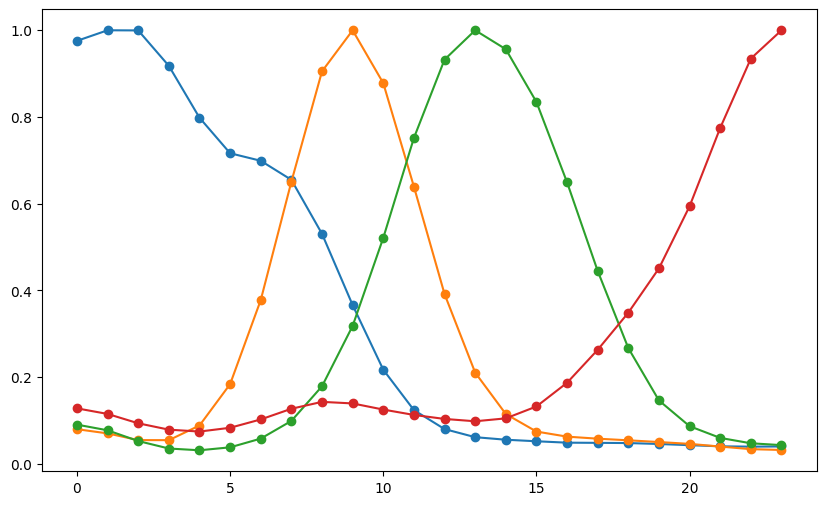

In [163]:
norms = []
plt.rcParams["figure.figsize"] = [10, 6]
for _, attention in word_attentions:
    attention = torch.reshape(attention, attention_map_size)
    attention = cv2.GaussianBlur(attention.cpu().numpy(), (7, 7), 0)
    cols = attention.sum(axis=0)
    norm = cols / cols.max()
    norms.append(torch.tensor(norm))
    plt.plot(norms[-1].cpu(), "-o")

From this, we estimate the spaces between the words by taking the intersection of each pair of consecutive words.

In [164]:
spaces = []
for w1, w2 in zip(norms, norms[1:]):
    m1 = w1.argmax()
    m2 = w2.argmax()
    intersection_idx = torch.argwhere(w1[m1 : m2 + 1] <= w2[m1 : m2 + 1])[0][0]
    spaces.append(int(intersection_idx + m1))

Draw the estimated spaces on the original image.

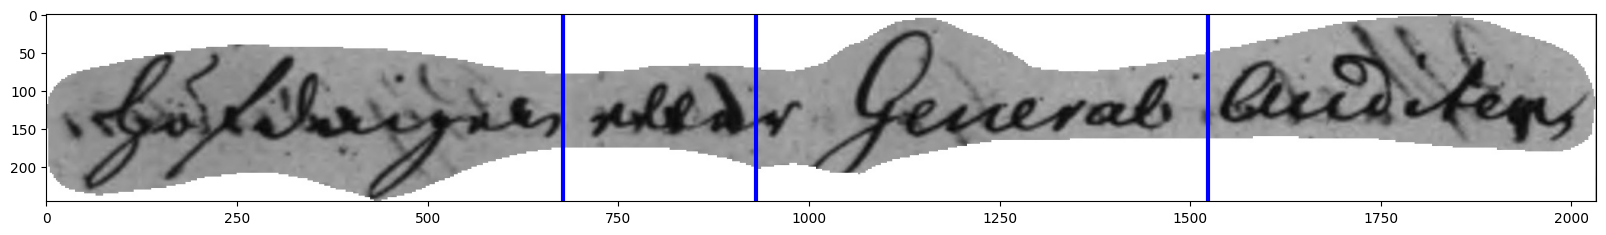

In [165]:
plt.rcParams["figure.figsize"] = [20, 10]
h, w = img.shape[:2]
for x in spaces:
    x = int(x / attention_map_size[1] * w)
    plt.plot([x, x], [0, h], color="blue", linewidth=3)
plt.imshow(img)